<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

#### 사전에 다운 받은 패키지 불러오기

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/prototype_model')

Mounted at /content/drive


#### matplotlib 한글 깨짐 해결 코드

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,747 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

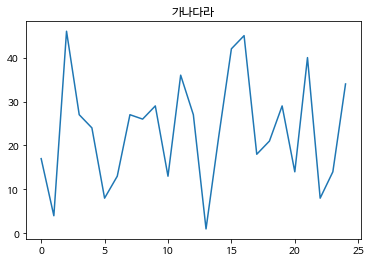

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 앞으로 사용할 패키지 불러오기

## 데이터 불러오기

In [3]:
import pandas as pd

under_train = pd.read_csv("./data/sample_data.csv")
under_train.groupby("class").count().iloc[:,0]

class
0    896
1    896
2    896
3    896
4    896
Name: Unnamed: 0, dtype: int64

#### 훈련셋 검증셋 나누기

In [5]:
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

X = under_train["pre_conversation"].to_list()
Y = under_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


## LSTM 적용하기

#### Tokenizing

In [17]:
!pip install sentencepiece
!pip install konlpy

     |████████████████████████████████| 19.4 MB 479 kB/s 
     |████████████████████████████████| 448 kB 74.9 MB/s 


In [29]:
import sentencepiece as spm

spm_path = "./bpe_10000_train_spm.model"
tokenizer = spm.SentencePieceProcessor()
tokenizer.Load(spm_path)

True

In [32]:
import re

vocab_size = int("".join(re.findall("[0-9]", spm_path)))
print(vocab_size)

10000


In [25]:
token_x_train = [tokenizer.EncodeAsIds(x) for x in x_train]
token_x_val = [tokenizer.EncodeAsIds(x) for x in x_val]
token_x_test = [tokenizer.EncodeAsIds(x) for x in x_test]

In [26]:
max_length_train = max(map(lambda x : len(x), token_x_train))
max_length_val = max(map(lambda x : len(x), token_x_val))
max_length_test = max(map(lambda x : len(x), token_x_test))
max_length = max([max_length_test, max_length_val, max_length_train])
max_length

333

#### 최대 길이로 패딩

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


padded_x_train = pad_sequences(token_x_train, maxlen = max_length)
print(padded_x_train.shape)
padded_x_val = pad_sequences(token_x_val, maxlen = max_length)
print(padded_x_val.shape)
padded_x_test = pad_sequences(token_x_test, maxlen = max_length)
print(padded_x_test.shape)

y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

(4032, 333)
(224, 333)
(224, 333)


#### Tensorflow dataset으로 변환

In [28]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((padded_x_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((padded_x_val, y_val))
val_dataset = val_dataset.shuffle(1000).batch(16)
tmp_x, tmp_y = next(iter(train_dataset))
print(tmp_x)
print("\n")
print(tmp_y)

tf.Tensor(
[[   0    0    0 ... 8916 9062   33]
 [   0    0    0 ... 9057  328   60]
 [   0    0    0 ...  534   89 2384]
 ...
 [   0    0    0 ...  157 3200 8913]
 [   0    0    0 ... 3761  354 1477]
 [   0    0    0 ... 3901 9037  148]], shape=(16, 333), dtype=int32)


tf.Tensor(
[[4]
 [3]
 [2]
 [4]
 [1]
 [1]
 [1]
 [2]
 [4]
 [3]
 [0]
 [1]
 [4]
 [0]
 [2]
 [3]], shape=(16, 1), dtype=int64)


#### Functional API LSTM model

In [33]:
inputs = tf.keras.layers.Input(shape = (padded_x_train.shape[1]))
layers = tf.keras.layers.Embedding(input_dim = vocab_size,
                                   output_dim = 128)(inputs)

layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)
layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)

layers = tf.keras.layers.LSTM(128, return_sequences = True)(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)
layers = tf.keras.layers.LSTM(128)(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)

layers = tf.keras.layers.Dense(128, activation = "relu")(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)
layers = tf.keras.layers.Dense(16, activation = "relu")(layers)
outputs = tf.keras.layers.Dense(5, activation = "softmax")(layers)

model = tf.keras.Model(inputs, outputs)

In [34]:
model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 333, 64)           49408     
                                                                 
 dropout (Dropout)           (None, 333, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 333, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 333, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 333, 128)          98816 

LSTM layer에서 Dense layer로 갈때는 return_sequences = False로 바꾸고 y_train shape를 (16,) -> (16, 1)로 바꾸었습니다.

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

model.fit(train_dataset,
          epochs = 10,
          batch_size = 16,
          validation_data = val_dataset,
          callbacks = [callback_earlystop])

Epoch 1/10
252/252 [==============================] - 24s 62ms/step - loss: 1.1152 - accuracy: 0.4442 - val_loss: 0.9148 - val_accuracy: 0.5625
Epoch 2/10
252/252 [==============================] - 14s 58ms/step - loss: 0.6908 - accuracy: 0.7071 - val_loss: 0.8242 - val_accuracy: 0.6964
Epoch 3/10
252/252 [==============================] - 14s 57ms/step - loss: 0.3822 - accuracy: 0.8663 - val_loss: 0.7833 - val_accuracy: 0.7545
Epoch 4/10
252/252 [==============================] - 14s 57ms/step - loss: 0.1831 - accuracy: 0.9462 - val_loss: 0.7887 - val_accuracy: 0.7991
Epoch 5/10
252/252 [==============================] - 14s 57ms/step - loss: 0.1182 - accuracy: 0.9638 - val_loss: 0.7839 - val_accuracy: 0.7902
Epoch 6/10
252/252 [==============================] - 14s 57ms/step - loss: 0.0712 - accuracy: 0.9802 - val_loss: 0.7672 - val_accuracy: 0.8259
Epoch 7/10
252/252 [==============================] - 14s 57ms/step - loss: 0.0717 - accuracy: 0.9831 - val_loss: 0.7870 - val_accuracy:

#### 모델 저장하기

In [39]:
model_path = "./model/LSTM-model/LSTM_10epoch_model.h5"
model.save(model_path)

## LSTM 모델 평가하기

In [40]:
loaded_model = tf.keras.models.load_model(model_path)

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

y_pred = np.argmax(loaded_model.predict(padded_x_test), axis = -1)
y_true = y_test.reshape(-1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        45
           1       0.83      0.67      0.74        45
           2       0.98      0.89      0.93        45
           3       0.61      0.86      0.72        44
           4       1.00      1.00      1.00        45

    accuracy                           0.84       224
   macro avg       0.86      0.84      0.84       224
weighted avg       0.86      0.84      0.84       224



## 사후 평가

In [42]:
false_list = []
for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [43]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_true, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
5,조용히 이혼하고 이 집만 넘겨 당신이 무슨 자격으로 무슨 자격이라니 잊었나본데 당신...,1,3
8,앗 뜨거 뭐하시는거에요 그쪽 담뱃불에 데였잖아요 담배 들고만 있었는데 근처로 온 사...,0,1
16,어머어머 스카프 이쁘다 너 아 남자친구가 사줬어 우와 좋겠네 능력있는 남자친구가 이...,1,3
18,야 이자식 명품입었네 벗어봐 나도 사려고하던건데 입어만보자 네 저 이거 벗으면 맨몸...,1,3
38,선배 제 뒷담 그만좀 하세요 내가 언제 이제 저도 지칩니다 들었어 어디서 많이 들었...,2,3
46,아 아줌마 어제 새벽에 왜 왔어요 아유 총각도 무슨 소리 하는거야 왜 왜 제 방에 ...,0,3
47,야 김민재 내가 너 공개수업시간에 손 들고 대답하라고 했어 안 했어 했어요 그렇게 ...,3,1
58,야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...,0,1
60,야 찐따 응 상철아 왜 매점 가서 빵 좀 사와 돈은 아나 지난번에 덜맞았나 니가 사...,1,3
63,선생님 저 이번 시험 점수 도저히 납득이 되질 않습니다 은혜야 갑자기 그게 무슨 말...,1,3


#### Confusion Matrix

Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

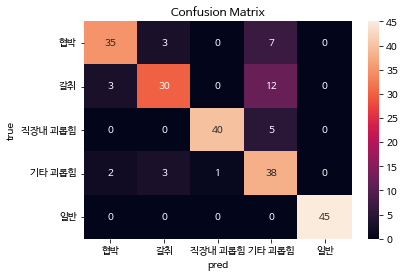

In [44]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.ylabel("true")
plt.xlabel("pred")
plt.show()

In [45]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,35,3,0,7,0
갈취,3,30,0,12,0
직장내 괴롭힘,0,0,40,5,0
기타 괴롭힘,2,3,1,38,0
일반,0,0,0,0,45
